In [28]:
#-- Select the variable of interest
variable = "Precac"

In [29]:
Testing = False # if True, only 200 files will be used

In [30]:
# import functions from my_functions.py file
import sys
sys.path.append('/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start')
from my_functions import *

In [35]:
#-- Condition if Precac; Load segmentation relation file 
if variable == "Precac":
    df = loadRelTable()
    if Testing == False:
        num_df_files = len(df['path_dyamond']) - 1 # -1 because the last one is nan
    else:
        num_df_files = 200 ### For testing

In [36]:
#-- Condition if not Precac; Search for files containing the desired characters
if not variable == "Precac":
    matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
    if Testing == False:
        sorted_files = sorted(matching_files)
    else:
        sorted_files = sorted_files[:200] ### For testing

In [37]:
#-- initialize lists containing spatial mean over time and the times
data_list = [] 
timestamp_list = []

In [38]:
#-- Iterate through the timestamps and populate the arrays with a progress bar

from tqdm import tqdm

if not variable == "Precac":
    
    for i, file in tqdm(enumerate(sorted_files), total=len(sorted_files), desc='Processing'):

        # Access data
        data = xr.open_dataset(file)
        variable_data = data[variable]
        
        # Calculate spatial mean
        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.values[0]

        # Getting timestamp
        start_marker = "DYAMOND_9216x4608x74_7.5s_4km_4608_"
        end_marker = f".{variable}.2D.nc"

        start_index = file.index(start_marker) + len(start_marker)
        end_index = file.index(end_marker)

        time_stamp = file[start_index:end_index]

        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)
        
        # Delete data and remove from memory
        del data
        del mean_lonlat
        del mean_lonlat_value
        del variable_data
        gc.collect
        
else:
    
    for seg_index in tqdm(range(num_df_files), desc='Processing'):
        
        # Handling edge case: making data the same for 0 and 1 index
        if seg_index == 0:
                seg_index = 1

        # Load data
        prec = loadPrec(seg_index,df)
        prec_filename = loadPrecacFilename(seg_index, df)
        time_stamp = prec_filename[90:100]

        # Replace negative values with NaN
        variable_data = xr.where(prec < 0, np.nan, prec)
        
        # Calculate spatial mean

        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.item()  # Convert scalar to a Python float
    
        
        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)

        # Delete data and remove from memory
        del prec
        del prec_filename
        del variable_data
        gc.collect
        

# Convert lists to arrays
data = np.array(data_list)
timestamps_array = np.array(timestamp_list)

# Print the resulting array
print(data)
print(timestamps_array)

Processing: 100%|██████████| 1918/1918 [03:34<00:00,  8.95it/s]

[0.00740355 0.00740355 0.01401846 ... 0.12751529 0.11386847 0.1071744 ]
['0000000960' '0000000960' '0000001200' ... '0000460320' '0000460560'
 '0000460800']


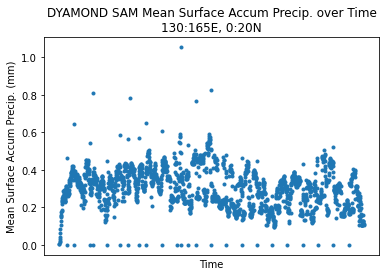

In [41]:
#-- plotting

name_dict = {"OM500":"Pressure velocity at 500 mb", "T2mm":"2-m temperature", "OM850":"Pressure velocity at 850 mb", "Precac":"Surface Accum Precip.", "PW":"Precipitable Water", "CWP":"Cloud Water Path", "U10m":"10-m zonal wind", "RH500":"Relative Humidity 500mb", "PSFC":"P at the surface","V10m":"10-m meridional wind","SHF":"Sensible Heat Flux", "LHF":"Latent Heat Flux"}
unit_dict = {"OM500":"Pa/s","T2mm":"K", "OM850":"Pa/s","Precac":"mm", "PW":"kg/m²", "CWP":"kg/m²", "U10m":"m/s", "RH500":"", "PSFC":"mbar", "V10m":"m/s","SHF":"W/m²", "LHF":"W/m²"}
var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)



fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array, data, marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'Mean {var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM Mean {var_name} over Time\n130:165E, 0:20N')


plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
# save_path = os.path.join(save_folder, f'{variable}_timeseries_test1.png')
# plt.savefig(save_path)

plt.show()

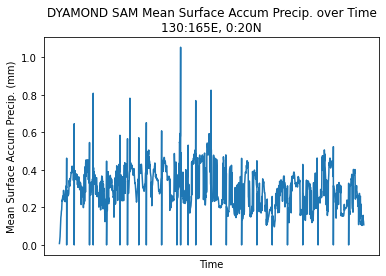

In [42]:
fig, ax = plt.subplots()

if variable == "Precac":
    timestamps_array, data = zip(*[(ts, d) for ts, d in zip(timestamps_array, data) if d <= 2])
    ax.plot(timestamps_array, data)
ax.set_xlabel('Time')
ax.set_ylabel(f'Mean {var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM Mean {var_name} over Time\n130:165E, 0:20N')


plt.xticks([])
# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
# save_path = os.path.join(save_folder, f'{variable}_timeseries_test1.png')
# plt.savefig(save_path)

plt.show()